In [65]:
import os
import pickle
import pandas as pd
import re
from pydantic import BaseModel
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from apple_message_parser import ImmaculateGridResult
import numpy as np
from copy import deepcopy 

In [66]:
INPUT_GRID_RESULTS_FILE_PATH = '~/Desktop/GitHub/immaculate_grid_mlb_analysis/output.p'
INPUT_PROMPT_DATA_PATH = '~/Desktop/GitHub/immaculate_grid_mlb_analysis/immaculate_grid_prompt_data.csv'
COLOR_MAP = {"Sam": "red", "Keith": "blue", "Will": "purple", "Rachel": "green", "Cliff": "orange"}

# Expand user directory and open the pickle file
with open(os.path.expanduser(INPUT_GRID_RESULTS_FILE_PATH), 'rb') as file:
    # Deserialize the object from the pickle file
    texts = pickle.load(file)

# Get current grid number, by selecting the max index from all input results
current_grid_number = max([max(texts[person].keys()) for person in texts])

# Make a dictionary called "reversed_dict" that is the reverse of texts
reversed_dict = {}
for name, grids in texts.items():
    for grid_number, obj in grids.items():
        reversed_dict.setdefault(grid_number, {})[name] = obj


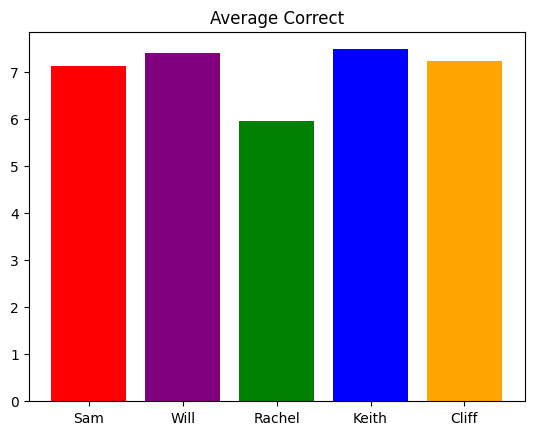

In [68]:
# Graph average correct
average_correct = []
for person in texts:
    data = [obj.correct for obj in texts[person].values()]
    average_correct.append(sum(data) / len(data))
plt.bar([person for person in texts], average_correct, color=[COLOR_MAP[person] for person in texts])
plt.title("Average Correct")
plt.show()

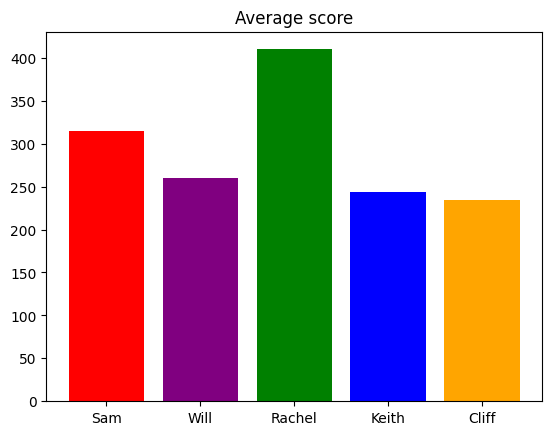

In [69]:
# Graph average score
average_score = []
for person in texts:
    data = [obj.score for obj in texts[person].values()]
    average_score.append(sum(data) / len(data))
plt.bar([person for person in texts], average_score, color=[COLOR_MAP[person] for person in texts])
plt.title("Average score")
plt.show()

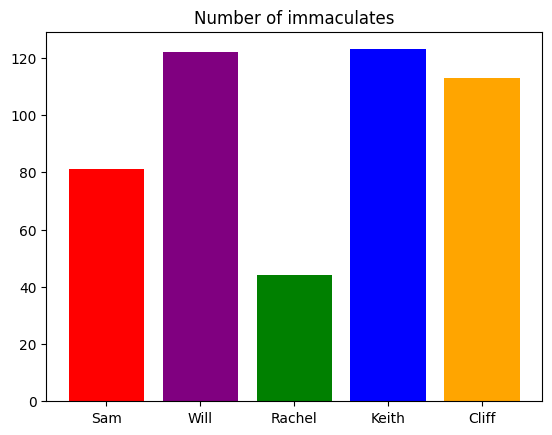

In [70]:
# Graph number of immaculates
counts = []
for person in texts:
    data = [(1 if obj.correct == 9 else 0) for obj in texts[person].values()]
    counts.append(sum(data))
plt.bar([person for person in texts], counts, color=[COLOR_MAP[person] for person in texts])
plt.title("Number of immaculates")
plt.show()

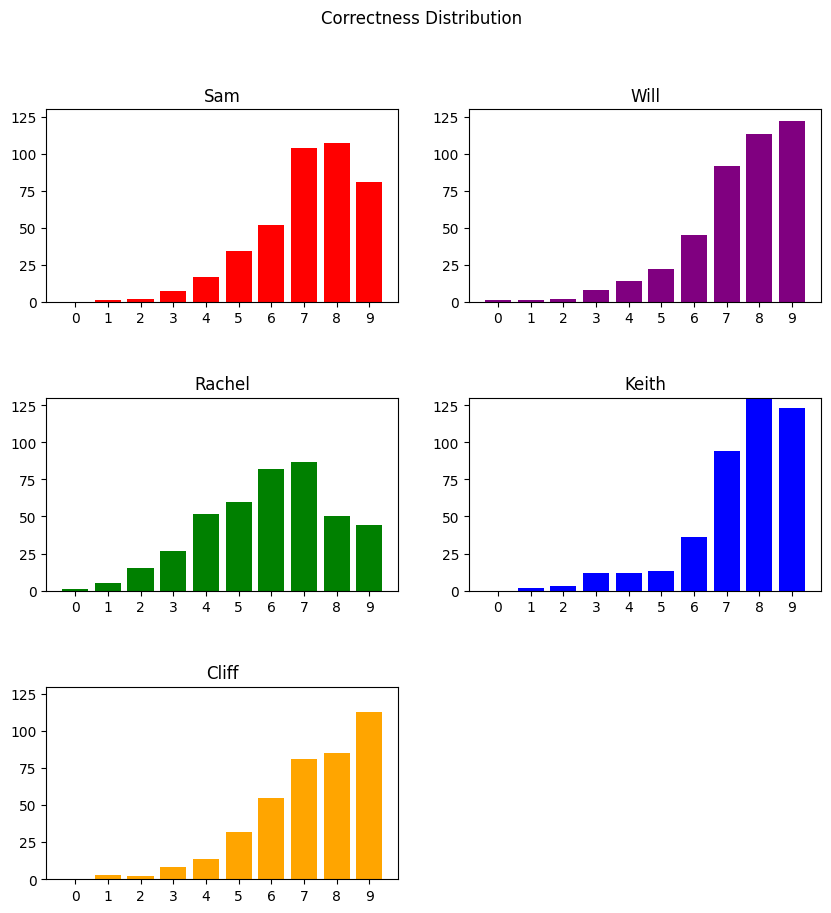

In [71]:
# Graph distributions
fig, axs = plt.subplots(3, 2, figsize=(10, 10))  # Create a 3x2 grid for 5 plots
top_bar = 130

# Flatten the axes array for easier indexing
axs = axs.flatten()

for i, person in enumerate(texts):
    distribution = [0 for _ in range(0, 10)]
    for row in texts[person].values():
        distribution[row.correct] += 1
    
    # Plotting the distribution for each person
    axs[i].bar(range(0, 10), distribution, color=COLOR_MAP[person])
    axs[i].set_xticks(range(0, 10))
    axs[i].set_title(person)
    axs[i].set_ylim(0, top_bar)

# Hide the last subplot if it is not used
if len(texts) < 6:
    axs[5].set_visible(False)

fig.suptitle("Correctness Distribution")
plt.subplots_adjust(hspace=0.5)
plt.show()


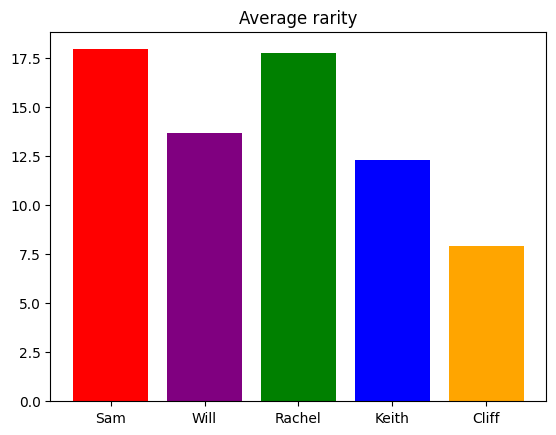

In [72]:
average_rarity = []
for person in texts:
    total_correct_scores = 0
    total_correct = 0
    for obj in texts[person].values():
        total_correct_scores += obj.score - (100 * (9 - obj.correct))
        total_correct += obj.correct
    average_rarity.append(total_correct_scores / total_correct)
plt.bar([person for person in texts], average_rarity, color=[COLOR_MAP[person] for person in texts])
plt.title("Average rarity")
plt.show()

AttributeError: Can only use .dt accessor with datetimelike values

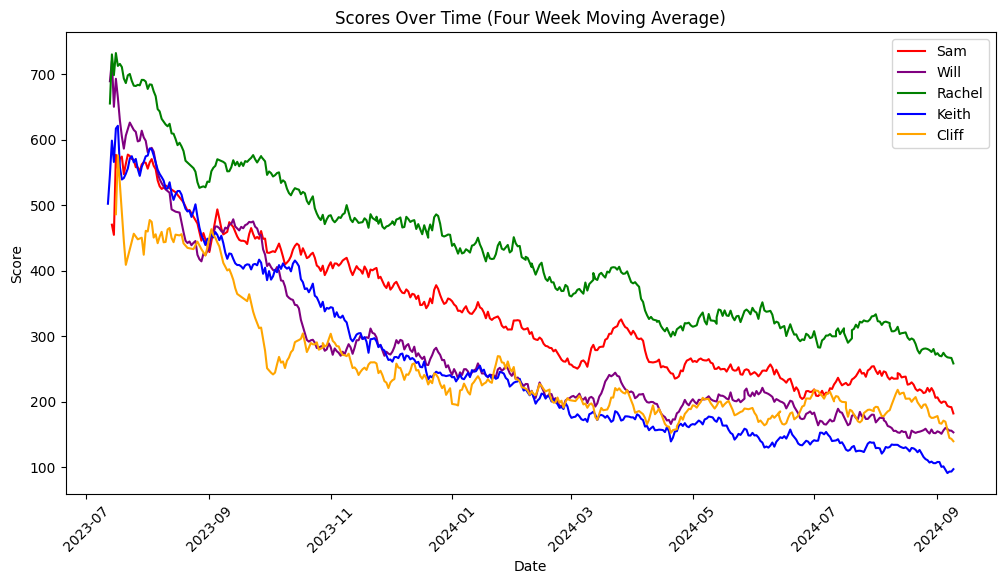

In [126]:
# Plot 1: Rarity over time

def calculate_rarity_smoothed_scores(texts, current_grid_number, min_range=100, smoothness=28):
    """
    Calculate smoothed rarity scores for each person over time.

    Args:
        texts (dict): Dictionary containing person data.
        current_grid_number (int): The number of grid entries to consider.
        min_range (int): Minimum range of scores to consider for smoothing.
        smoothness (int): Number of scores to average for smoothness.

    Returns:
        pd.DataFrame: A DataFrame containing smoothed rarity scores.
    """
    rows = []

    for person in texts:
        total_correct_scores = []
        total_correct = []
        dates = []

        for i in range(current_grid_number):
            if i in texts[person] and (texts[person][i].score < 900 or texts[person][i].correct == 0):
                obj = texts[person][i]
                total_correct_scores.append(obj.score - (100 * (9 - obj.correct)))
                total_correct.append(obj.correct)
                dates.append(obj.date)
            else:
                total_correct_scores.append(None)
                total_correct.append(None)
                dates.append(None)

        # Calculate smoothed rarity scores
        for i in range(min_range + smoothness, current_grid_number):
            score_sub = [x for x in total_correct_scores[i - smoothness:i] if x is not None]
            correct_sub = [x for x in total_correct[i - smoothness:i] if x is not None]
            date_sub = [dates[j] for j in range(i - smoothness, i) if dates[j] is not None]

            if correct_sub:
                smoothed_score = sum(score_sub) / sum(correct_sub)
                smoothed_date = date_sub[-1]

                rows.append({
                    'Person': person,
                    'Date': smoothed_date,
                    'Smoothed Rarity Score': smoothed_score
                })

    return pd.DataFrame(rows)

def plot_rarity_scores(output_table):
    """Plot the smoothed rarity scores over time."""
    plt.figure(figsize=(12, 6))

    for person in output_table['Person'].unique():
        person_data = output_table[output_table['Person'] == person]
        plt.plot(person_data['Date'], person_data['Smoothed Rarity Score'], 
                 label=person, color=COLOR_MAP[person])

    # Formatting the plot
    plt.legend()
    plt.title("Rarity Over Time (Four Week Moving Average)")
    plt.xlabel("Date")
    plt.ylabel("Rarity Score")
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_formatter(plt.FixedFormatter(person_data['Date'].dt.strftime('%b %Y')))
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins='auto'))

    plt.show()

# Plot 2: Scores over time

def calculate_scores_and_dates(person_data, current_grid_number):
    """
    Calculate total scores and dates for a person.
    
    Args:
        person_data (dict): Data for a specific person containing scores and dates.
        current_grid_number (int): The current grid number to iterate up to.

    Returns:
        tuple: Lists of total scores and corresponding dates.
    """
    total_scores = []
    dates = []

    for i in range(current_grid_number):
        if i in person_data:
            total_scores.append(person_data[i].score)
            dates.append(person_data[i].date)
        else:
            total_scores.append(None)
            dates.append(None)

    return total_scores, dates

def calculate_smoothed_scores(total_scores, smoothness, dates):
    """
    Smooth scores using a moving average and associate dates.
    
    Args:
        total_scores (list): List of scores.
        smoothness (int): Number of periods to smooth over.
        dates (list): Corresponding list of dates.

    Returns:
        list: Smoothed scores along with their grid numbers and dates.
    """
    smoothed_scores = []

    for i in range(smoothness, len(total_scores)):
        window = total_scores[i - smoothness:i]
        valid_scores = [score for score in window if score is not None]  # Filter out None values
        
        if valid_scores:  # If there are valid scores in the window
            smoothed_scores.append((i, sum(valid_scores) / len(valid_scores), dates[i]))
        else:
            smoothed_scores.append((i, None, dates[i]))  # Append None if all values are None

    return smoothed_scores

def generate_score_table(texts, smoothness, current_grid_number):
    """
    Generate a DataFrame of smoothed scores over time.
    
    Args:
        texts (dict): Dictionary of scores for each person.
        smoothness (int): Number of periods to smooth over.
        current_grid_number (int): Current grid number to iterate up to.

    Returns:
        DataFrame: A DataFrame with columns for person, grid number, smoothed score, and date.
    """
    score_table = []

    for person, person_data in texts.items():
        total_scores, dates = calculate_scores_and_dates(person_data, current_grid_number)
        smoothed_scores = calculate_smoothed_scores(total_scores, smoothness, dates)

        score_table.extend((person, grid_number, score, date) for grid_number, score, date in smoothed_scores)

    # Create DataFrame and drop rows with NaN values
    column_names = ("Person", "Grid Number", "Smoothed Score", "Date")
    df = pd.DataFrame(score_table, columns=column_names).dropna()

    return df

def plot_score_over_time(output_table):
    """Plot the smoothed scores over time."""
    plt.figure(figsize=(12, 6))

    for person in output_table['Person'].unique():
        person_data = output_table[output_table['Person'] == person]
        plt.plot(person_data['Date'], person_data['Smoothed Score'], 
                 label=person, color=COLOR_MAP[person])

    # Formatting the plot
    plt.legend()
    plt.title("Scores Over Time (Four Week Moving Average)")
    plt.xlabel("Date")
    plt.ylabel("Score")
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_formatter(plt.FixedFormatter(person_data['Date'].dt.strftime('%b %Y')))
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins='auto'))

    plt.tight_layout()  # Adjust layout for better display
    plt.show()

# Usage
smoothness = 28
rarity_table = calculate_rarity_smoothed_scores(texts, current_grid_number)
plot_rarity_scores(rarity_table)

score_table = generate_score_table(texts, smoothness, current_grid_number)
score_table['Date'] = pd.to_datetime(score_table['Date']).dt.date  # Keep only the date part
plot_score_over_time(score_table)


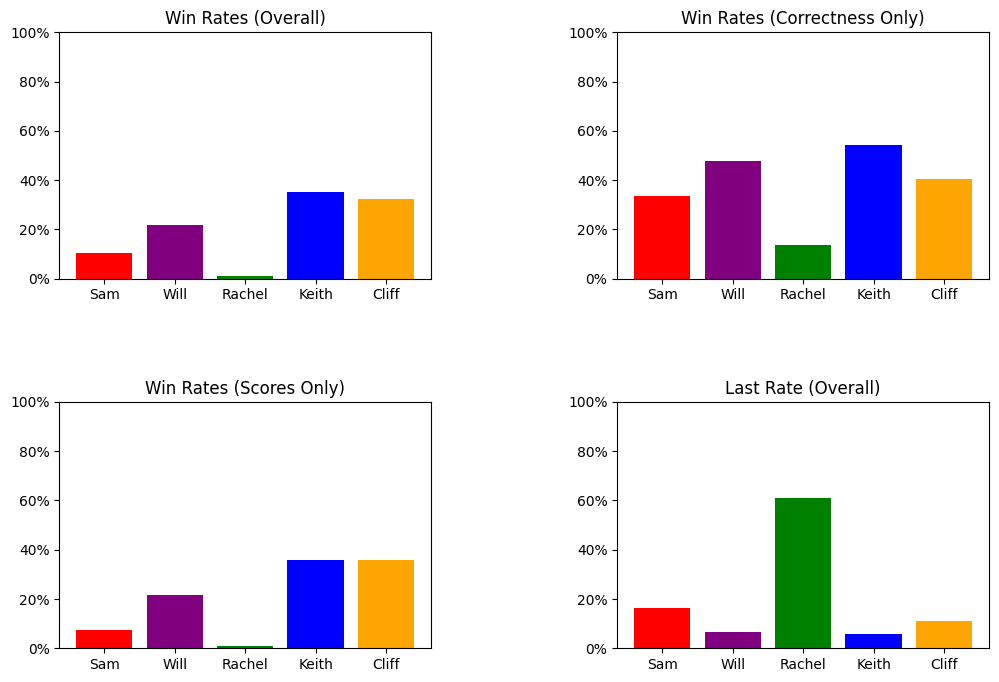

In [120]:
def to_percent(y, position):
    """Convert a decimal to a percentage string."""
    return f"{100 * y:.0f}%"

def calculate_win_rates(reversed_dict, criterion):
    """
    Calculate win rates based on a given criterion.

    Args:
        reversed_dict (dict): The games data.
        criterion (str): The criterion to calculate win rates ("overall", "correctness", "scores", "last_rate").

    Returns:
        dict: A dictionary of win rates for each person.
    """
    wins = {person: 0 for person in texts}
    for game in reversed_dict.values():
        if criterion == "overall":
            best = max((game[person].correct * 1000) + (1000 - game[person].score) for person in game)
            for person in game:
                effective_score = (game[person].correct * 1000) + (1000 - game[person].score)
                if effective_score == best:
                    wins[person] += 1
        elif criterion == "correctness":
            best = max(game[person].correct for person in game)
            for person in game:
                if game[person].correct == best:
                    wins[person] += 1
        elif criterion == "scores":
            best = min(game[person].score for person in game)
            for person in game:
                if game[person].score == best:
                    wins[person] += 1
        elif criterion == "last_rate":
            best = min((game[person].correct * 1000) + (1000 - game[person].score) for person in game)
            for person in game:
                effective_score = (game[person].correct * 1000) + (1000 - game[person].score)
                if effective_score == best:
                    wins[person] += 1

    for person in wins:
        wins[person] /= len(reversed_dict.values())

    return wins

def plot_win_rates(texts, reversed_dict):
    """Plot win rates based on various criteria."""
    # Set a larger figure size to widen the graphs
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    criteria = ["overall", "correctness", "scores", "last_rate"]
    titles = ["Win Rates (Overall)", "Win Rates (Correctness Only)", "Win Rates (Scores Only)", "Last Rate (Overall)"]

    for ax, criterion, title in zip(axs.flat, criteria, titles):
        wins = calculate_win_rates(reversed_dict, criterion)
        ax.bar([person for person in wins], wins.values(), color=[COLOR_MAP[person] for person in wins])
        ax.set_title(title)
        ax.set_yticks([i / 5 for i in range(6)])
        ax.set_ylim(0, 1)
        ax.yaxis.set_major_formatter(FuncFormatter(to_percent))

    # Adjust the layout of the subplots
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    plt.show()

# Usage
plot_win_rates(texts, reversed_dict)


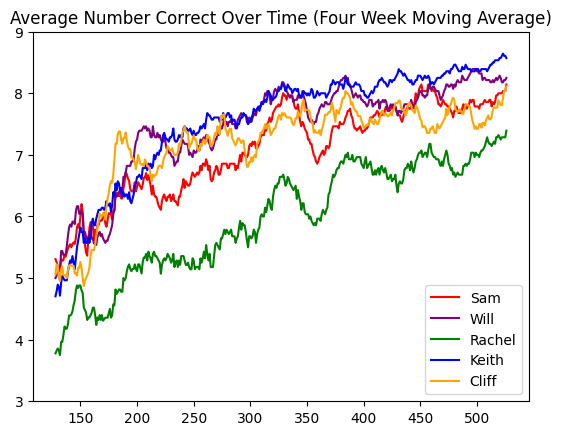

In [121]:
min_range = 100
smoothness = 28
average_rarity = []
for person in texts:
    total_scores = []
    for i in range(current_grid_number):
        if i in texts[person] and (texts[person][i].score < 900 or texts[person][i].correct == 0):
            obj = texts[person][i]
            total_scores.append(obj.correct)
        else:
            total_scores.append(None)

    smoothed_scores = []
    range_val = []
    for i in range(min_range + smoothness, current_grid_number):
        score_sub = [x for x in filter(lambda x: x is not None, total_scores[i - smoothness:i])]
        if score_sub:
            smoothed_scores.append(sum(score_sub) / len(score_sub))
            range_val.append(i)

    plt.plot(range_val, smoothed_scores, label=person, color=COLOR_MAP[person])
plt.legend()
plt.ylim(3, 9)
plt.title("Average Number Correct Over Time (Four Week Moving Average)")
plt.show()

In [54]:
restructured = []
for person in texts:
    for grid_number, obj in texts[person].items():
        restructured.append({"person": person, "game": grid_number, "correct": obj.correct, "score": obj.score, "date": obj.date})
csv_df = pd.DataFrame(restructured)

In [55]:
csv_df.to_csv("./immaculate_grid_stats.csv")

In [122]:
score_records = []
for person, games in texts.items():
    for id, game in games.items():
        score_records.append((person, game.score, game.date, id))

print("Best:")
sorted_records = sorted(score_records, key=lambda x: x[1])
for i, (name, record, date, game_id) in enumerate(sorted_records[0:25]):
    print(i + 1, name, record, date)

print("\n\nWorst:")
for i in range(25):
    name, record, date, game_id = sorted_records[len(sorted_records) - i - 1]
    print(i + 1, name, record, date)

Best:
1 Keith 4 2024-06-14
2 Cliff 5 2024-01-29
3 Cliff 6 2023-11-24
4 Will 8 2024-07-13
5 Keith 8 2024-06-28
6 Cliff 8 2023-12-09
7 Will 9 2023-10-28
8 Cliff 9 2024-07-13
9 Will 10 2024-01-15
10 Will 10 2024-09-07
11 Cliff 10 2024-03-16
12 Cliff 10 2024-06-02
13 Cliff 11 2024-03-30
14 Will 12 2024-04-27
15 Cliff 12 2024-01-15
16 Cliff 12 2024-09-06
17 Keith 13 2024-08-03
18 Cliff 13 2024-08-01
19 Will 14 2024-06-14
20 Keith 14 2024-07-21
21 Cliff 14 2023-10-28
22 Will 15 2024-08-10
23 Rachel 15 2024-07-13
24 Cliff 16 2023-11-29
25 Keith 17 2024-02-28


Worst:
1 Rachel 900 2023-09-01
2 Will 900 2023-09-01
3 Rachel 891 2023-08-30
4 Rachel 852 2023-11-20
5 Rachel 833 2023-07-15
6 Keith 828 2023-08-30
7 Cliff 825 2023-08-10
8 Rachel 825 2023-12-22
9 Rachel 825 2023-07-28
10 Will 825 2023-07-28
11 Rachel 823 2023-08-01
12 Keith 821 2023-07-15
13 Will 821 2023-07-15
14 Sam 821 2023-07-15
15 Sam 817 2023-11-02
16 Cliff 816 2023-09-01
17 Rachel 806 2023-12-28
18 Keith 805 2023-08-01
19 Rachel

In [60]:
##### Everything below this line incorporates prompt data



with open(os.path.expanduser(INPUT_PROMPT_DATA_PATH)) as f:
    prompt_df = pd.read_csv(f, header=None)
prompt_df.columns = ["game_id", "00", "01", "02", "10", "11", "12", "20", "21", "22"]
prompt_df = prompt_df.iloc[1:]

new_rows = []
for i, row in prompt_df.iterrows():
    new_row = {}
    for col, val in row.items():
        for char in ["(", "'", ")"]:
            val = val.replace(char, "")
        new_row[col] = val.replace(", ", " + ")
    new_rows.append(new_row)
        

prompt_df = pd.DataFrame(new_rows)
prompt_df['game_id'] = prompt_df['game_id'].astype(int)

In [61]:
team_list = ["Cubs", "Cardinals", "Brewers", "Reds", "Pirates", "Nationals", "Mets", "Marlins", "Phillies", "Braves", "Dodgers", "Diamondbacks", "Rockies", "Giants", "Padres", "Royals", "White Sox", "Twins", "Guardians", "Tigers", "Red Sox", "Yankees", "Blue Jays", "Rays", "Orioles", "Angels", "Athletics", "Astros", "Mariners", "Rangers"]

def is_team(category):
    for team in team_list:
        if team in category:
            return True
    return False

def get_team(category):
    for team in team_list:
        if team in category:
            return team
    return ""

In [62]:
def get_categories(prompt):
    parts = prompt.split(" + ")
    return parts[0].strip(), parts[1].strip()

categories = set()
for person, games in texts.items():
    for id, game in games.items():
        prompt_rows = prompt_df[prompt_df["game_id"] == id]
        if len(prompt_rows) != 1:
            continue
        prompts = prompt_rows.iloc[0][1:]
        for prompt in prompts:
            part_one, part_two = get_categories(prompt)
            categories.add(part_one)
            categories.add(part_two)

person_to_category = {}
for person, _ in texts.items():
    person_to_category[person] = {cat: [0, 0] for cat in categories}

In [63]:

for person, games in texts.items():
    for id, game in games.items():
        prompt_rows = prompt_df[prompt_df["game_id"] == id]
        if len(prompt_rows) != 1:
            continue
        prompts = prompt_rows.iloc[0][1:]

        matrix = game.matrix
        for i in range(3):
            for j in range(3):
                part_one, part_two = get_categories(prompts[f"{i}{j}"])
                if matrix[i][j]:
                    person_to_category[person][part_one][0] += 1
                    person_to_category[person][part_two][0] += 1
                person_to_category[person][part_one][1] += 1
                person_to_category[person][part_two][1] += 1

In [64]:
threshold = 25
categories_to_count = {}
for category in categories:
    categories_to_count[category] = []
for _, value in person_to_category.items():
    for category, (correct, total) in value.items():
        categories_to_count[category].append(total)
categories_clearing_threshold = [cat for cat in filter(lambda x: sum(categories_to_count[x]) / len(categories_to_count[x]) > threshold, categories_to_count)]


In [65]:
types = ["Team-Team", "Team-Stat", "Stat-Stat"]
person_to_type = {person: {t: [0, 0] for t in types} for person in person_to_category}

for person, games in texts.items():
    for id, game in games.items():
        prompt_rows = prompt_df[prompt_df["game_id"] == id]
        if len(prompt_rows) != 1:
            continue
        prompts = prompt_rows.iloc[0][1:]

        matrix = game.matrix
        for i in range(3):
            for j in range(3):
                part_one, part_two = get_categories(prompts[f"{i}{j}"])
                tag = ""
                if is_team(part_one) and is_team(part_two):
                    tag = "Team-Team"
                elif is_team(part_one) != is_team(part_two):
                    tag = "Team-Stat"
                else:
                    tag = "Stat-Stat"
                if matrix[i][j]:
                    person_to_type[person][tag][0] += 1
                person_to_type[person][tag][1] += 1

In [66]:
for person in person_to_type:
    print(person)
    for tag in person_to_type[person]:
        acc = person_to_type[person][tag][0] / person_to_type[person][tag][1]
        print(f"{tag}: {round(100 * acc)}% ({person_to_type[person][tag][1]})")
    print()

Keith
Team-Team: 75% (1395)
Team-Stat: 85% (1677)
Stat-Stat: 91% (456)

Will
Team-Team: 66% (1358)
Team-Stat: 90% (1655)
Stat-Stat: 95% (452)

Sam
Team-Team: 59% (1272)
Team-Stat: 89% (1599)
Stat-Stat: 92% (441)

Rachel
Team-Team: 38% (1360)
Team-Stat: 79% (1660)
Stat-Stat: 92% (454)



In [67]:
for person, value in person_to_category.items():
    rankings = sorted([(cat, value[cat][0] / value[cat][1], value[cat][1]) for cat in value], key=lambda x: x[1], reverse=True)

    print(f"====={person}=====")
    count = 1
    for i, (category, accuracy, total) in enumerate(rankings):
        if total > threshold:
            print(f"{count}. {category} ({round(accuracy, 2)}) ({total})")
            count += 1
    print("\n\n")

=====Keith=====
1. 40+ WAR Career (1.0) (57)
2. Hall of Fame (0.99) (129)
3. 300+ HR Career Batting (0.98) (63)
4. 200+ Wins Career Pitching (0.98) (54)
5. 6+ WAR Season (0.98) (54)
6. Played Outfield min. 1 game (0.98) (42)
7. Pitched min. 1 game (0.97) (36)
8. All Star (0.97) (135)
9. New York Mets (0.97) (168)
10. 30+ HR Season Batting (0.96) (57)
11. 2000+ K Career Pitching (0.96) (48)
12. 10+ Win Season Pitching (0.96) (48)
13. 2000+ Hits Career Batting (0.95) (66)
14. .300+ AVG Season Batting (0.95) (87)
15. Born Outside US 50 States and DC (0.95) (75)
16. New York Yankees (0.95) (183)
17. 100+ RBI Season Batting (0.92) (90)
18. 100+ Run Season Batting (0.92) (48)
19. Played First Base min. 1 game (0.9) (42)
20. Washington Nationals (0.9) (135)
21. Played Catcher min. 1 game (0.9) (51)
22. Only One Team (0.89) (66)
23. Played In Major Negro Lgs (0.89) (27)
24. â‰¤ 3.00 ERA Season (0.88) (60)
25. Boston   Red Sox (0.88) (186)
26. Played Center Field min. 1 game (0.88) (42)
27. 40+

In [68]:
overall = []
for category in categories:
    values = []
    counts = []
    for person in person_to_category:
        values.append(person_to_category[person][category][0] / person_to_category[person][category][1])
        counts.append(person_to_category[person][category][1])
    if is_team(category):
        overall.append((category, sum(values) / len(values)))

print("Consensus Easiest Teams")
overall = sorted(overall, key=lambda x: x[1], reverse=True)
for i, (category, avg) in enumerate(overall):
    print(f"{(i + 1)}. {category} ({round(100 * avg)}%)")

Consensus Easiest Teams
1. Chicago Cubs (92%)
2. New York Yankees (87%)
3. New York Mets (86%)
4. Boston   Red Sox (83%)
5. Washington Nationals (81%)
6. Los Angeles Dodgers (80%)
7. Texas Rangers (74%)
8. Houston Astros (72%)
9. Atlanta Braves (71%)
10. Oakland Athletics (71%)
11. St. Louis Cardinals (71%)
12. Philadelphia Phillies (69%)
13. San Francisco Giants (69%)
14. Cincinnati Reds (67%)
15. Los Angeles Angels (66%)
16. Chicago  White Sox (65%)
17. Cleveland Guardians (65%)
18. Baltimore Orioles (64%)
19. Detroit Tigers (64%)
20. Pittsburgh Pirates (63%)
21. Seattle Mariners (63%)
22. San Diego Padres (62%)
23. Toronto  Blue Jays (62%)
24. Arizona Diamondbacks (61%)
25. Milwaukee Brewers (60%)
26. Minnesota Twins (60%)
27. Kansas City Royals (59%)
28. Miami Marlins (58%)
29. Tampa Bay Rays (57%)
30. Colorado Rockies (51%)


In [69]:
overall = []
for category in categories:
    values = []
    counts = []
    for person in person_to_category:
        values.append(person_to_category[person][category][0] / person_to_category[person][category][1])
        counts.append(person_to_category[person][category][1])
    if is_team(category):
        overall.append((category, np.std(values)))

print("Biggest Team Standard Deviations")
overall = sorted(overall, key=lambda x: x[1], reverse=True)
for i, (category, avg) in enumerate(overall):
    print(f"{(i + 1)}. {category} ({round(100 * avg)}%)")

Biggest Team Standard Deviations
1. Baltimore Orioles (16%)
2. San Diego Padres (15%)
3. Milwaukee Brewers (14%)
4. Minnesota Twins (14%)
5. Pittsburgh Pirates (13%)
6. Miami Marlins (13%)
7. San Francisco Giants (13%)
8. Philadelphia Phillies (12%)
9. Seattle Mariners (12%)
10. Toronto  Blue Jays (12%)
11. Kansas City Royals (11%)
12. Detroit Tigers (11%)
13. Los Angeles Angels (11%)
14. Tampa Bay Rays (11%)
15. Atlanta Braves (11%)
16. Los Angeles Dodgers (11%)
17. Cincinnati Reds (11%)
18. Texas Rangers (10%)
19. Houston Astros (10%)
20. Cleveland Guardians (10%)
21. Oakland Athletics (10%)
22. Arizona Diamondbacks (10%)
23. St. Louis Cardinals (10%)
24. New York Yankees (7%)
25. Boston   Red Sox (7%)
26. Colorado Rockies (7%)
27. New York Mets (7%)
28. Chicago  White Sox (7%)
29. Washington Nationals (6%)
30. Chicago Cubs (5%)


In [70]:
overall = []
for category in filter(is_team, categories):

    max_acc = 0
    for person in person_to_category:
        acc = person_to_category[person][category][0] / person_to_category[person][category][1]
        if acc > max_acc:
            max_acc = acc

    max_people = []
    for person in person_to_category:
        acc = person_to_category[person][category][0] / person_to_category[person][category][1]
        if abs(acc - max_acc) < 0.0001:
            max_people.append(person)
    
    overall.append((category, ", ".join(max_people)))

print("Best Person for Each Team")
for category, people in sorted(overall, key=lambda x: x[0]):
    print(category, "\t" if len(category) > 14 else "\t\t", people)
    


Best Person for Each Team
Arizona Diamondbacks 	 Keith
Atlanta Braves 		 Keith
Baltimore Orioles 	 Keith
Boston   Red Sox 	 Keith
Chicago  White Sox 	 Will
Chicago Cubs 		 Will
Cincinnati Reds 	 Will
Cleveland Guardians 	 Will
Colorado Rockies 	 Keith
Detroit Tigers 		 Keith
Houston Astros 		 Will
Kansas City Royals 	 Keith
Los Angeles Angels 	 Keith
Los Angeles Dodgers 	 Will
Miami Marlins 		 Keith
Milwaukee Brewers 	 Keith
Minnesota Twins 	 Keith
New York Mets 		 Keith
New York Yankees 	 Keith
Oakland Athletics 	 Keith
Philadelphia Phillies 	 Keith
Pittsburgh Pirates 	 Will
San Diego Padres 	 Keith
San Francisco Giants 	 Keith
Seattle Mariners 	 Keith
St. Louis Cardinals 	 Keith
Tampa Bay Rays 		 Keith
Texas Rangers 		 Will
Toronto  Blue Jays 	 Keith
Washington Nationals 	 Keith


In [71]:
overall = []
for category in filter(is_team, categories):

    min_acc = 101
    for person in person_to_category:
        acc = person_to_category[person][category][0] / person_to_category[person][category][1]
        if acc < min_acc:
            min_acc = acc

    min_people = []
    for person in person_to_category:
        acc = person_to_category[person][category][0] / person_to_category[person][category][1]
        if abs(acc - min_acc) < 0.0001:
            min_people.append(person)
    
    overall.append((category, ", ".join(min_people)))

print("Worst Person for Each Team")
for category, people in sorted(overall, key=lambda x: x[0]):
    print(category, "\t" if len(category) > 14 else "\t\t", people)
    

Worst Person for Each Team
Arizona Diamondbacks 	 Rachel
Atlanta Braves 		 Rachel
Baltimore Orioles 	 Rachel
Boston   Red Sox 	 Rachel
Chicago  White Sox 	 Rachel
Chicago Cubs 		 Keith
Cincinnati Reds 	 Rachel
Cleveland Guardians 	 Rachel
Colorado Rockies 	 Rachel
Detroit Tigers 		 Rachel
Houston Astros 		 Rachel
Kansas City Royals 	 Rachel
Los Angeles Angels 	 Rachel
Los Angeles Dodgers 	 Rachel
Miami Marlins 		 Rachel
Milwaukee Brewers 	 Rachel
Minnesota Twins 	 Rachel
New York Mets 		 Rachel
New York Yankees 	 Rachel
Oakland Athletics 	 Rachel
Philadelphia Phillies 	 Rachel
Pittsburgh Pirates 	 Rachel
San Diego Padres 	 Rachel
San Francisco Giants 	 Rachel
Seattle Mariners 	 Rachel
St. Louis Cardinals 	 Rachel
Tampa Bay Rays 		 Rachel
Texas Rangers 		 Rachel
Toronto  Blue Jays 	 Rachel
Washington Nationals 	 Rachel


In [72]:
overall = []
for category in filter(lambda x: not is_team(x) and x in categories_clearing_threshold, categories):

    max_acc = 0
    for person in person_to_category:
        acc = person_to_category[person][category][0] / person_to_category[person][category][1]
        if acc > max_acc:
            max_acc = acc

    max_people = []
    for person in person_to_category:
        acc = person_to_category[person][category][0] / person_to_category[person][category][1]
        if abs(acc - max_acc) < 0.0001:
            max_people.append(person)
    
    overall.append((category, ", ".join(max_people)))

print("Best Person for Each Category")
for category, people in sorted(overall, key=lambda x: x[0]):
    print(category, "\t" if len(category) > 14 else "\t\t", people)
    

Best Person for Each Category
.300+ AVG Career Batting 	 Will
.300+ AVG Season Batting 	 Will
10+ Win Season Pitching 	 Will, Sam
100+ RBI Season Batting 	 Sam
100+ Run Season Batting 	 Sam
20+ Win Season Pitching 	 Will
200+ Hits Season Batting 	 Will
200+ K Season Pitching 	 Will
200+ Wins Career Pitching 	 Keith, Will
2000+ Hits Career Batting 	 Will
2000+ K Career Pitching 	 Will
30+ HR Season Batting 	 Will, Rachel
30+ SB Season 		 Sam
30+ Save Season Pitching 	 Keith
300+ HR Career Batting 	 Keith
3000+ Hits Career Batting 	 Will
40+ HR Season Batting 	 Will
40+ WAR Career 		 Keith, Sam, Rachel
6+ WAR Season 		 Keith, Sam
All Star 		 Will, Sam
Born Outside US 50 States and DC 	 Will
Cy Young 		 Will
First Round Draft Pick 	 Sam
Gold Glove 		 Will
Hall of Fame 		 Keith
MVP 		 Will
Only One Team 		 Sam
Pitched min. 1 game 	 Will
Played Catcher min. 1 game 	 Keith
Played Center Field min. 1 game 	 Sam
Played First Base min. 1 game 	 Keith, Will
Played In Major Negro Lgs 	 Will
Playe

In [73]:
overall = []
for category in filter(lambda x: not is_team(x) and x in categories_clearing_threshold, categories):

    min_acc = 101
    for person in person_to_category:
        acc = person_to_category[person][category][0] / person_to_category[person][category][1]
        if acc < min_acc:
            min_acc = acc

    min_people = []
    for person in person_to_category:
        acc = person_to_category[person][category][0] / person_to_category[person][category][1]
        if abs(acc - min_acc) < 0.0001:
            min_people.append(person)
    
    overall.append((category, ", ".join(min_people)))

print("Worst Person for Each Category")
for category, people in sorted(overall, key=lambda x: x[0]):
    print(category, "\t" if len(category) > 14 else "\t\t", people)
    

Worst Person for Each Category
.300+ AVG Career Batting 	 Keith
.300+ AVG Season Batting 	 Rachel
10+ Win Season Pitching 	 Rachel
100+ RBI Season Batting 	 Rachel
100+ Run Season Batting 	 Keith, Rachel
20+ Win Season Pitching 	 Keith, Rachel
200+ Hits Season Batting 	 Rachel
200+ K Season Pitching 	 Rachel
200+ Wins Career Pitching 	 Sam, Rachel
2000+ Hits Career Batting 	 Rachel
2000+ K Career Pitching 	 Rachel
30+ HR Season Batting 	 Keith, Sam
30+ SB Season 		 Keith
30+ Save Season Pitching 	 Rachel
300+ HR Career Batting 	 Rachel
3000+ Hits Career Batting 	 Keith
40+ HR Season Batting 	 Rachel
40+ WAR Career 		 Will
6+ WAR Season 		 Rachel
All Star 		 Keith
Born Outside US 50 States and DC 	 Rachel
Cy Young 		 Rachel
First Round Draft Pick 	 Rachel
Gold Glove 		 Keith
Hall of Fame 		 Rachel
MVP 		 Keith
Only One Team 		 Rachel
Pitched min. 1 game 	 Keith, Sam, Rachel
Played Catcher min. 1 game 	 Rachel
Played Center Field min. 1 game 	 Rachel
Played First Base min. 1 game 	 Sam, 

In [74]:
hardest_teams = {}

for person, games in texts.items():
    hardest_teams[person] = {team: [0, 0] for team in team_list}
    for id, game in games.items():
        prompt_rows = prompt_df[prompt_df["game_id"] == id]
        if len(prompt_rows) != 1:
            continue
        prompts = prompt_rows.iloc[0][1:]

        matrix = game.matrix
        for i in range(3):
            for j in range(3):
                part_one, part_two = get_categories(prompts[f"{i}{j}"])
                tag = ""
                if is_team(part_one) and is_team(part_two):
                    team_one = get_team(part_one)
                    team_two = get_team(part_two)
                    if matrix[i][j]:
                        hardest_teams[person][team_one][0] += 1
                        hardest_teams[person][team_two][0] += 1
                    hardest_teams[person][team_one][1] += 1
                    hardest_teams[person][team_two][1] += 1

print("Hardest Team-Team Intersections for Each Person", "\n\n")
for person in hardest_teams:
    print(f"====={person}=====")
    for i, (team, res) in enumerate(sorted(hardest_teams[person].items(), key = lambda x: x[1][0] / x[1][1], reverse=True)):
        print(f"{i + 1}. {team} ({round(100 * res[0] / res[1])}%)")
    print("\n\n\n")

consensus_intersection_difficulty = {}
for team in team_list:
    right = 0
    total = 0
    for person in hardest_teams:
        res = hardest_teams[person][team]
        right += res[0]
        total += res[1]
    consensus_intersection_difficulty[team] = right / total
    
print("=====Consensus=====")
for i, (team, pct) in enumerate(sorted(consensus_intersection_difficulty.items(), key=lambda x: x[1], reverse=True)):
    print(f"{i + 1}. {team} ({round(100 * pct)}%)")


Hardest Team-Team Intersections for Each Person 


=====Keith=====
1. Mets (96%)
2. Yankees (95%)
3. Red Sox (89%)
4. Nationals (89%)
5. Dodgers (88%)
6. Cubs (87%)
7. Cardinals (84%)
8. Giants (83%)
9. Athletics (80%)
10. Phillies (77%)
11. Rangers (76%)
12. Padres (76%)
13. Orioles (75%)
14. Braves (74%)
15. Angels (74%)
16. Astros (74%)
17. Mariners (74%)
18. Marlins (72%)
19. Brewers (71%)
20. Tigers (71%)
21. White Sox (70%)
22. Guardians (68%)
23. Blue Jays (67%)
24. Diamondbacks (67%)
25. Rays (65%)
26. Pirates (63%)
27. Royals (63%)
28. Twins (61%)
29. Reds (54%)
30. Rockies (52%)




=====Will=====
1. Cubs (96%)
2. Dodgers (85%)
3. Yankees (85%)
4. Mets (77%)
5. Rangers (77%)
6. Red Sox (74%)
7. Reds (74%)
8. Nationals (73%)
9. Athletics (72%)
10. Astros (70%)
11. Braves (70%)
12. Angels (68%)
13. Guardians (68%)
14. Orioles (68%)
15. Pirates (68%)
16. White Sox (67%)
17. Phillies (64%)
18. Twins (61%)
19. Cardinals (61%)
20. Diamondbacks (60%)
21. Giants (60%)
22. Padres (58%

In [75]:
hardest_team_stats = {}

for person, games in texts.items():
    hardest_team_stats[person] = {team: [0, 0] for team in team_list}
    for id, game in games.items():
        prompt_rows = prompt_df[prompt_df["game_id"] == id]
        if len(prompt_rows) != 1:
            continue
        prompts = prompt_rows.iloc[0][1:]

        matrix = game.matrix
        for i in range(3):
            for j in range(3):
                part_one, part_two = get_categories(prompts[f"{i}{j}"])
                tag = ""
                if is_team(part_one) and not is_team(part_two):
                    team_one = get_team(part_one)
                    if matrix[i][j]:
                        hardest_team_stats[person][team_one][0] += 1
                    hardest_team_stats[person][team_one][1] += 1
                elif not is_team(part_one) and is_team(part_two):
                    team_two = get_team(part_two)
                    if matrix[i][j]:
                        hardest_team_stats[person][team_two][0] += 1
                    hardest_team_stats[person][team_two][1] += 1

print("Hardest Team-Stats Intersections for Each Person", "\n\n")
for person in hardest_team_stats:
    print(f"====={person}=====")
    for i, (team, res) in enumerate(sorted(hardest_team_stats[person].items(), key = lambda x: x[1][0] / x[1][1], reverse=True)):
        print(f"{i + 1}. {team} ({round(100 * res[0] / res[1])}%)")
    print("\n\n\n")

consensus_intersection_difficulty = {}
for team in team_list:
    right = 0
    total = 0
    for person in hardest_teams:
        res = hardest_team_stats[person][team]
        right += res[0]
        total += res[1]
    consensus_intersection_difficulty[team] = right / total
    
print("=====Consensus=====")
for i, (team, pct) in enumerate(sorted(consensus_intersection_difficulty.items(), key=lambda x: x[1], reverse=True)):
    print(f"{i + 1}. {team} ({round(100 * pct)}%)")

Hardest Team-Stats Intersections for Each Person 


=====Keith=====
1. Mets (99%)
2. Giants (94%)
3. Nationals (94%)
4. Yankees (94%)
5. Phillies (93%)
6. Twins (92%)
7. Braves (91%)
8. Padres (91%)
9. Astros (90%)
10. Marlins (89%)
11. Red Sox (88%)
12. Reds (87%)
13. Tigers (87%)
14. Brewers (87%)
15. Mariners (87%)
16. Dodgers (85%)
17. Royals (84%)
18. Pirates (84%)
19. Cardinals (84%)
20. Rangers (83%)
21. Cubs (82%)
22. Diamondbacks (81%)
23. Angels (81%)
24. Rockies (80%)
25. Rays (80%)
26. Orioles (79%)
27. Athletics (76%)
28. Blue Jays (73%)
29. Guardians (71%)
30. White Sox (65%)




=====Will=====
1. Yankees (99%)
2. Red Sox (99%)
3. Astros (98%)
4. Mets (97%)
5. Cubs (97%)
6. Pirates (97%)
7. Nationals (96%)
8. Giants (96%)
9. Braves (94%)
10. Phillies (93%)
11. Dodgers (93%)
12. Cardinals (93%)
13. Royals (91%)
14. Athletics (89%)
15. Mariners (89%)
16. Tigers (89%)
17. Brewers (87%)
18. Orioles (87%)
19. Blue Jays (86%)
20. Rangers (86%)
21. Angels (85%)
22. Reds (85%)
23

In [76]:
most_common_exact_intersections = {}

for id, game in texts["Sam"].items():
    prompt_rows = prompt_df[prompt_df["game_id"] == id]
    if len(prompt_rows) != 1:
        continue
    prompts = prompt_rows.iloc[0][1:]
    for i in range(3):
        for j in range(3):
            part_one, part_two = get_categories(prompts[f"{i}{j}"])
            key = " + ".join(sorted([part_one, part_two]))
            if key not in most_common_exact_intersections:
                most_common_exact_intersections[key] = 0
            most_common_exact_intersections[key] += 1

for i, (combo, count) in enumerate(sorted(most_common_exact_intersections.items(), key = lambda x: x[1], reverse=True)):
    if count >= 5:
        print(f"{i + 1}. {combo} ({count})")

1. Detroit Tigers + St. Louis Cardinals (6)
2. Chicago  White Sox + Minnesota Twins (6)
3. Boston   Red Sox + Philadelphia Phillies (6)
4. Cleveland Guardians + Oakland Athletics (6)
5. Boston   Red Sox + New York Yankees (6)
6. Houston Astros + New York Mets (6)
7. Milwaukee Brewers + Toronto  Blue Jays (5)
8. Boston   Red Sox + New York Mets (5)
9. Baltimore Orioles + Philadelphia Phillies (5)
10. All Star + Toronto  Blue Jays (5)
11. San Francisco Giants + Toronto  Blue Jays (5)
12. New York Mets + Texas Rangers (5)
13. Hall of Fame + New York Yankees (5)
14. Los Angeles Angels + San Francisco Giants (5)
15. Cincinnati Reds + Kansas City Royals (5)
16. Boston   Red Sox + Oakland Athletics (5)
17. Atlanta Braves + Chicago Cubs (5)
18. Chicago Cubs + Oakland Athletics (5)
19. Houston Astros + San Francisco Giants (5)
20. Oakland Athletics + San Francisco Giants (5)
21. Atlanta Braves + Pittsburgh Pirates (5)
22. Chicago Cubs + Detroit Tigers (5)
23. Boston   Red Sox + Texas Rangers (5

In [77]:
team_to_full_names = {}
full_names_to_team = {}
for team in team_list:
    for category in categories:
        if team in category:
            team_to_full_names[team] = category
            full_names_to_team[category] = team
            

missing = 0
present = 0
missing_maps = {}
print("Empty Team-Team Intersections")
for i, team in enumerate(sorted(team_list)):
    for other in sorted(team_list)[i + 1:]:
        key = " + ".join([team_to_full_names[team], team_to_full_names[other]])
        other_key =  " + ".join([team_to_full_names[other], team_to_full_names[team]])
        if key not in most_common_exact_intersections and other_key not in most_common_exact_intersections:
            print(key)
            missing += 1
            if team not in missing_maps:
                missing_maps[team] = 0
            if other not in missing_maps:
                missing_maps[other] = 0
            missing_maps[team] += 1
            missing_maps[other] += 1
        else:
            present += 1    

print("\n\n\n\nTotal Missing")
for i, (team, count) in enumerate(sorted(missing_maps.items(), key=lambda x: x[1], reverse=True)):
    if count > 0:
        print(f"{i + 1}. {team} ({count})")

Empty Team-Team Intersections
Los Angeles Angels + Tampa Bay Rays
Toronto  Blue Jays + Colorado Rockies
Atlanta Braves + Tampa Bay Rays
Milwaukee Brewers + Colorado Rockies
Chicago Cubs + Arizona Diamondbacks
Chicago Cubs + Miami Marlins
Arizona Diamondbacks + Miami Marlins
Arizona Diamondbacks + Colorado Rockies
San Francisco Giants + Miami Marlins
Miami Marlins + Washington Nationals
Miami Marlins + Tampa Bay Rays
Miami Marlins + Colorado Rockies
Baltimore Orioles + Tampa Bay Rays
Tampa Bay Rays + Colorado Rockies




Total Missing
1. Marlins (6)
2. Rays (5)
3. Rockies (5)
4. Diamondbacks (3)
5. Cubs (2)
6. Angels (1)
7. Blue Jays (1)
8. Braves (1)
9. Brewers (1)
10. Giants (1)
11. Nationals (1)
12. Orioles (1)


In [78]:
most_common_exact_intersections = {}

for id, game in texts["Rachel"].items():
    prompt_rows = prompt_df[prompt_df["game_id"] == id]
    if len(prompt_rows) != 1:
        continue
    prompts = prompt_rows.iloc[0][1:]
    for i in range(3):
        for j in range(3):
            part_one, part_two = get_categories(prompts[f"{i}{j}"])
            teams = [get_team(part_one), get_team(part_two)]
            if "Guardians" in teams and "Athletics" in teams:
                print(game.matrix[i][j])

False
False
False
False
True
True


In [ ]:
with open("./immaculate_grid_names.txt") as f:
    names = [line.strip() for line in f.readlines()]

In [ ]:
name_to_count = {}
for name in names:
    name_to_count[name] = name_to_count.get(name, 0) + 1
sorted_names = sorted(name_to_count.items(), key=lambda x: x[1], reverse=True)

In [ ]:
for i, (name, count) in enumerate(sorted_names):
    print(f"{i + 1}. {name} ({count})")

In [ ]:
def create_variants(existing, all):
    if len(existing) == 9:
        all.add("".join([str(x) for x in existing]))
        return
    create_variants(deepcopy(existing) + [0], all)
    create_variants(deepcopy(existing) + [1], all)
    return
combos = set()
create_variants([], combos)

In [ ]:
copied_variants = deepcopy(combos)
full_combos = set()
dates = []
for grid_num in range(current_grid_number):
    for person in texts:
        if grid_num not in texts[person]:
            continue
        obj = texts[person][grid_num]
        current = ""
        for text_row in obj.text.split("\n"):
            for char in text_row:
                if ord(char) == 11036: #"⬜️":
                    current += "0"
                elif ord(char) == 129001: #"🟩":
                    current += "1"
        assert len(current) == 9
        full_combos.add(current)
        if current in copied_variants:
            copied_variants.remove(current)
            dates.append((obj.date, grid_num, person, current, obj.text))

sorted_dates = sorted(dates, key = lambda x: x[1], reverse=True)
for date, _, person, combo, text in sorted_dates[:10]:
    print(person, date, "\n", text, end="\n\n\n")

In [ ]:
texts["Keith"][152]